# Generation of figure 2
Tim Tyree<br>
1.3.2022

In [1]:
from lib.my_initialization import *
from lib import *
%load_ext autoreload
%autoreload 2

import random,scipy
import matplotlib as mpl #for colorbar
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy import stats
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

In [2]:
#TODO(later): remake these plots with any a,D,r,kappa combination inside the bounds of the result of my >500 years of computation time
#HINT: interp=recall_particle_model_interp()  #estimated run time ~20 seconds

In [3]:
# #recall the fit of the particle model to the powerlaw fits from the full models
# wjr=recall_powerlaw_fits_to_full_models()
# print(*wjr)

In [4]:
# # recall_particle_parameter_fits 
# a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
# a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

# directly compute the powerlaws from the particle model with vector-summed inverse powerlaw attraction
- Nota Bene: this process is automated by my pythonic function recall_particle_model_interp from lib

In [5]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all_powerlaw_fits.csv"
df=pd.read_csv(input_fn)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
0,1.477497,0.017889,10.233038,0.458553,0.996691,0.254568,2.192560,fk_ncbc,0.1,1.0,...,1.6,9,0,10,2,0,0,0,0,0
1,1.726534,0.013938,18.451423,0.663628,0.998526,0.252599,0.849591,lr_pbc,0.1,1.0,...,1.0,9,0,10,2,0,1,0,0,0
2,1.361442,0.010685,34.324471,1.345462,0.998607,0.557511,10.602247,lr_pbc,0.1,1.0,...,1.2,90,0,10,2,0,1,0,0,0
3,3.050656,0.082928,110.878921,27.313205,0.983541,8.696932,40.571684,lr_pbc,0.1,1.0,...,1.6,1,0,10,2,0,0,0,0,0
4,1.961670,0.014691,3.008488,0.072870,0.998732,0.053220,1.228204,fk_pbc,0.1,1.0,...,1.9,1,0,10,2,0,0,0,0,0


In [6]:
r=0.1
kappa=500#250
D=0.7
# varkappa_lst=sorted(set(df['varkappa'].values))
# varkappa_lst

#TODO: extract xy values for kappa, r, D fixed to any value, which I can change later
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#template query for the DataFrame
query =(df.set_second==set_second)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
query&=df.r==r
query&=df.kappa==kappa
query&=df.D==D
query&=df.L==L
# query&=df.x0==x0
query_template=query.copy()

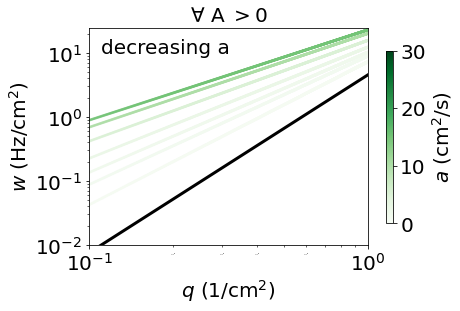

In [7]:
num_points = 25
c_col = 'rmse_full'
vmin = 0.
vmax = .25
fontsize = 20
x1lim = [1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
fig, ax = plt.subplots(figsize=(5,4))
varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values

    #scatter plot
    if varkappa==0:
        ax.plot(x_values,y_values,c='black',alpha=1.,lw=3)#,s=5)
        first_case=False
    else:
        ax.scatter(x_values,y_values,
               c=c_values,cmap='Greens',alpha=0.7,s=3,vmin=vmin,vmax=2*vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Greens
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

ax.annotate("decreasing a", xy=(0.3, 11), xytext=(0.11, 10),fontsize=fontsize)
ax.set_title(r'$\forall $ A $ > 0$',fontsize=fontsize)
# ax.set_title(r'For all A $ > 0$',fontsize=fontsize)
plt.show()

src 'generate figure effect of increasing a.ipynb':
- for D=0.7, kappa=250, r=0.1 fixed,
- the powerlaw OLS fit for loglog of M versus a
- m=0.34662844685683697
- Delta_m=0.007544034420649642
- b=1.5430792099954873
- Delta_b=0.023831286783598894
- Rsquared=0.9972947153026107

#  TODO: generate Fig. 2

In [8]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

In [9]:
#DONT: dev PlotScatter function for the full models
#input: ax, df=lr or fk, c='C0' or 'C1'
#output: True and plotted values
mpl.rcParams.update(matplotlib.rcParamsDefault)


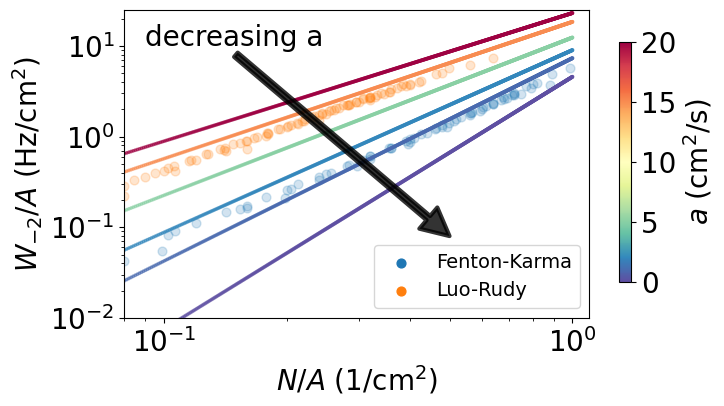

In [82]:
cmap='Spectral'+'_r'
num_points = 25
c_col = 'rmse_full'
fontsize = 20
xytext=(0.09, 10)
x1lim = [8e-2, 1.1]#[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize=(6,4)#(5,4)
fig, ax = plt.subplots(figsize=figsize)



# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = 20#np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot 
    ax.scatter(x_values,y_values,
               c=c_values,cmap=cmap,alpha=0.6,s=3,vmin=vmin,vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$N/A$ (1/cm$^{2}$)',#q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$W_{-2}/A$ (Hz/cm$^{2}$)',#w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot arrow annotation
ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
ax.annotate("", xy=(0.5, 0.08), xytext=(0.15, 8),#,zorder=-1e8,#zorder can send to back
            arrowprops=dict(lw=3,headwidth=20.,headlength=20.,color='k',alpha=0.8))#arrowstyle="->",

#TODO: add dashed-black line below a=0 with slope of exactly two
#TODO: mark the slope of ^that line with ~2

leg=ax.legend(loc='lower right',fontsize=fontsize-6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

In [83]:
print(f"Notes on Fig. 2")
print(f"kappa={kappa} Hz, r = {r} cm, D={D} cm^2/s, fixed.")
print(f"in order to make the particle model line up better with the FK model, I'll need to change r to 0.8 or 0.6 cm...")
print(f"^this would require a bit of coding, to use interp instead of df...")

Notes on Fig. 2
kappa=500 Hz, r = 0.1 cm, D=0.7 cm^2/s, fixed.
in order to make the particle model line up better with the FK model, I'll need to change r to 0.8 or 0.6 cm...
^this would require a bit of coding, to use interp instead of df...


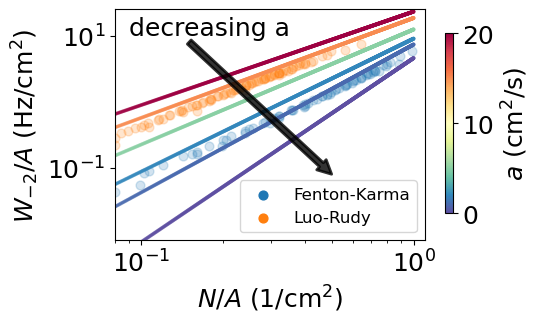

In [84]:
cmap='Spectral'+'_r'
num_points = 25
c_col = 'rmse_full'
fontsize = 18
xytext=(0.09, 10)
x1lim = [8e-2, 1.1]#[1e-1, 1]
x2lim = [8e-3, 25]
# x2lim = [4e-3, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize=(4,3)#(5,4)
fig, ax = plt.subplots(figsize=figsize)



# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = 20#np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot 
    ax.scatter(x_values,y_values,
               c=c_values,cmap=cmap,alpha=0.6,s=3,vmin=vmin,vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$N/A$ (1/cm$^{2}$)',#q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$W_{-2}/A$ (Hz/cm$^{2}$)',#w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot arrow annotation
ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
ax.annotate("", xy=(0.5, 0.08), xytext=(0.15, 8),#,zorder=-1e8,#zorder can send to back
            arrowprops=dict(lw=2,headwidth=10.,headlength=10.,color='k',alpha=0.8))#arrowstyle="->",

leg=ax.legend(loc='lower right',fontsize=fontsize-6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

In [12]:
# matplotlib.colors.get_named_colors_mapping()

In [13]:
#DONE(easy): plot the original full model annihilation rate measurements
#DONE: find previous "decreasing a" plot NOT from 'Generating Annihilation Rate Plots from Remote Cache of Particle Model.ipynb'
#TODO: merge ^those
#TODO: perform basic edits to match sketch